In [585]:
!pip install -r requirements.txt


[notice] A new release of pip available: 22.3 -> 24.1.2
[notice] To update, run: pip3 install --upgrade pip
Reshimming asdf python...


In [21]:
import crop_sim
import importlib
importlib.reload(crop_sim)

<module 'crop_sim' from '/Users/theron/code/crop-models/crop_sim.py'>

In [2]:
zip_codes = crop_sim.load_zip("33483")
print(zip_codes)

     ZIP  latitude  longitude
0  33483   26.4546   -80.0656


In [3]:
# crop_sim.generate_near()

In [4]:
loca_tasmin, loca_tasmax = crop_sim.load_temperature_data(zip_codes)

In [5]:
print(loca_tasmin)

<xarray.DataArray 'tasmin' (time: 731, lat: 16, lon: 16)> Size: 749kB
[187136 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 6kB 2022-01-01T12:00:00 ... 2024-01-01T12:...
  * lat      (lat) float64 128B 26.03 26.09 26.16 26.22 ... 26.84 26.91 26.97
  * lon      (lon) float64 128B 279.0 279.1 279.2 279.2 ... 279.8 279.9 280.0
Attributes:
    units:    K
    history:   pierce 2023-08-14 09:28:45.882494 /net/mead24/data/LOCA2_CONUS...
    region::  s_east


In [6]:
ecocrop_df = crop_sim.load_ecocrop()

In [7]:


# Select your crop of interest (replace 'Maize' with your desired crop)
# crop_name = 'Allium cepa' #onion
# crop_name= "Lycopersicon esculentum" # Tomatoes
# crop_name = "Brassica juncea" # Mustard greens
# crop_name = "Vigna unguiculata"
# crop_name = "Ipomoea batatas"
crop_name = "Solanum tuberosum" # Potato
bolting = False

tmin, tmax, topt_min, topt_max, gmin, gmax = crop_sim.load_crop_variables(ecocrop_df, crop_name)


In [8]:
zip_codes = crop_sim.add_loca_index(zip_codes, loca_tasmin, loca_tasmax)

In [9]:
print(zip_codes['loca_index'].values)

[(7, 14)]


In [10]:
lat, lon = zip_codes['loca_index'].values[0]

In [11]:
loca_tasmin_smoothed, loca_tasmax_smoothed = crop_sim.smooth_tas(loca_tasmin, loca_tasmax)

In [12]:
daily_suitability = crop_sim.suitability(bolting, loca_tasmin_smoothed, loca_tasmax_smoothed, tmin, tmax, topt_min, topt_max)

In [13]:
# print(daily_suitability.isel(lat=lat, lon=lon))

In [14]:
growing_season_suitability = crop_sim.calculate_season_suitability(gmin, gmax, daily_suitability)
optimal_planting_ranges = crop_sim.calculate_optimal_planting_ranges(growing_season_suitability, lat, lon)


In [15]:
view_window = 90
print(optimal_planting_ranges)

{90: [[Timestamp('2022-10-28 12:00:00'), Timestamp('2023-01-17 12:00:00')]], 100: [[Timestamp('2022-10-28 12:00:00'), Timestamp('2023-01-07 12:00:00')]], 110: [[Timestamp('2022-10-28 12:00:00'), Timestamp('2022-12-28 12:00:00')]], 120: [[Timestamp('2022-10-28 12:00:00'), Timestamp('2022-12-18 12:00:00')]], 130: [[Timestamp('2022-10-28 12:00:00'), Timestamp('2022-12-08 12:00:00')]], 140: [[Timestamp('2022-10-28 12:00:00'), Timestamp('2022-11-28 12:00:00')]], 150: [[Timestamp('2022-10-28 12:00:00'), Timestamp('2022-11-18 12:00:00')]], 160: [[Timestamp('2022-10-28 12:00:00'), Timestamp('2022-11-08 12:00:00')]]}


In [23]:
print(crop_sim.merge_overlapping_monthday_ranges(optimal_planting_ranges[90]))

[(10, 28, 1, 17)]


In [16]:
%matplotlib widget

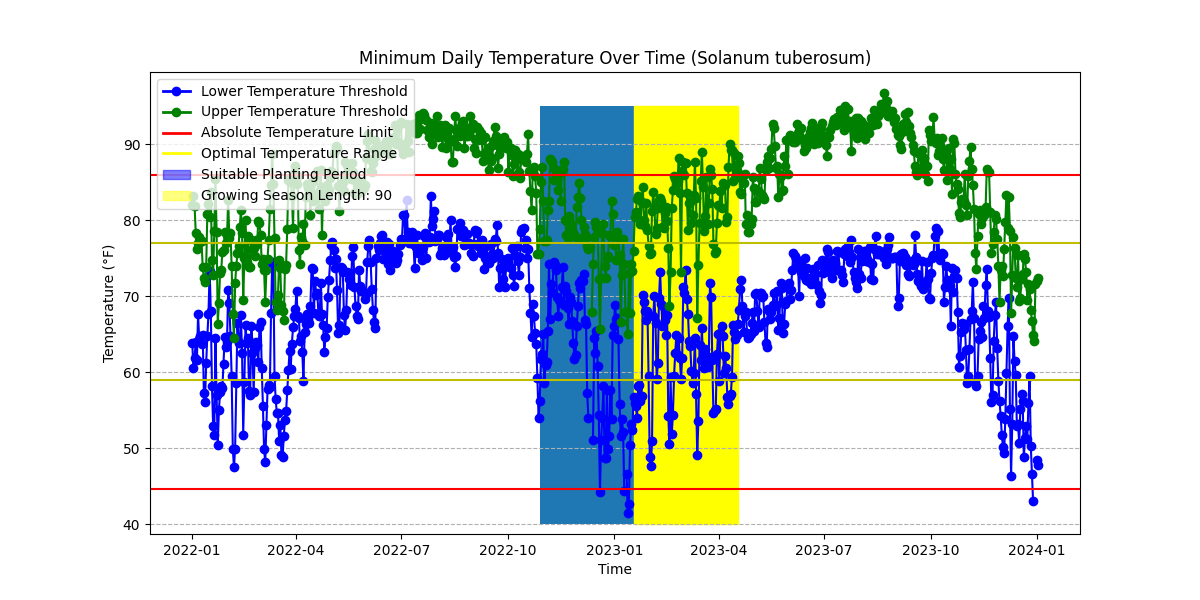

In [18]:
view_window = 90
crop_sim.plot_planting(loca_tasmin_smoothed, loca_tasmax_smoothed, tmin, tmax, topt_min, topt_max, view_window, optimal_planting_ranges, lat, lon, crop_name)


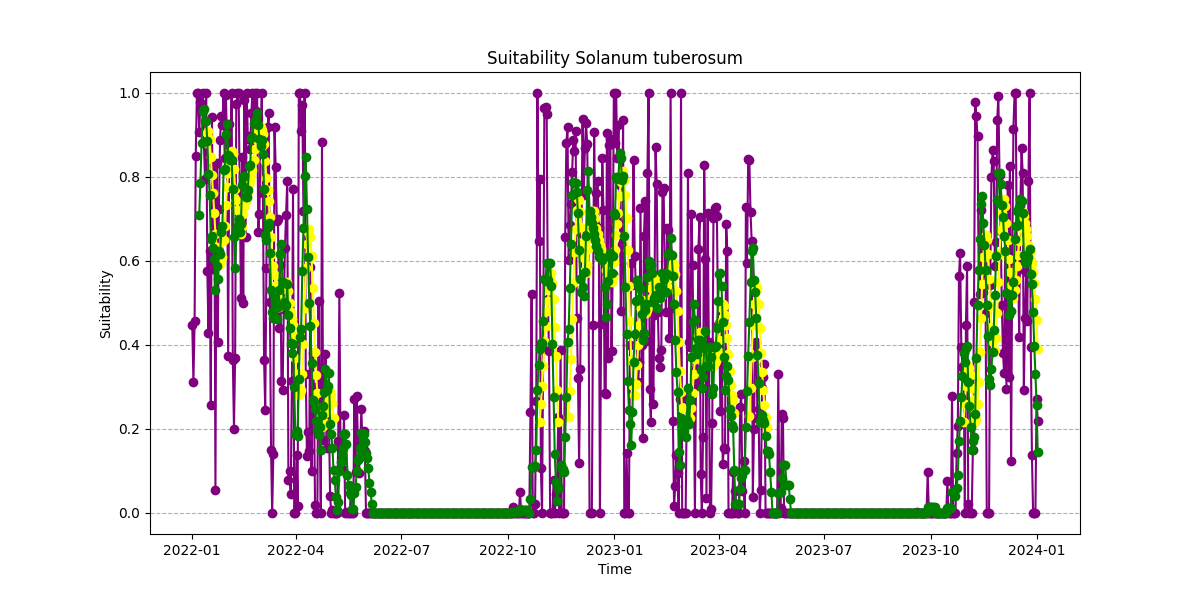

In [19]:
crop_sim.plot_suitability(view_window, growing_season_suitability, daily_suitability, lat, lon, crop_name)